In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe
from matplotlib.ticker import FormatStrFormatter

import os; print(os.getcwd())

import result_utils

/net/lem/data1/regt/retrieval_base/Luhman_16/figures


In [2]:
name_A = 'Luhman 16A'; name_B = 'Luhman 16B'
color_A = '#FF622E'; color_B = '#396ED8'

lw_d = 0.8
lw_m = 1.5

res_alpha = 0.85

A = result_utils.RetrievalResults('../retrieval_outputs/J_A_ret_21_1column_n1000/test_')
B = result_utils.RetrievalResults('../retrieval_outputs/J_B_ret_57_1column_n1000/test_')

../retrieval_outputs/J_A_ret_21_1column_n1000/test_data
  analysing data from ../retrieval_outputs/J_A_ret_21_1column_n1000/test_.txt
../retrieval_outputs/J_B_ret_57_1column_n1000/test_data
  analysing data from ../retrieval_outputs/J_B_ret_57_1column_n1000/test_.txt


In [3]:
A.load_components(['Chem', 'PT', 'Cloud', 'm_spec'])
B.load_components(['Chem', 'PT', 'Cloud', 'm_spec'])

In [4]:
contr_A = np.nansum(A.m_spec['J1226_1'].integrated_contr, axis=0)
contr_B = np.nansum(B.m_spec['J1226_1'].integrated_contr, axis=0)

In [5]:
cmap_A = mpl.colors.LinearSegmentedColormap.from_list('', ['w',color_A])
env_colors_A = cmap_A([0.4,0.6,0.8])
env_colors_A[:,3] = 0.5

cmap_B = mpl.colors.LinearSegmentedColormap.from_list('', ['w',color_B])
env_colors_B = cmap_B([0.4,0.6,0.8])
env_colors_B[:,3] = 0.5

3 21


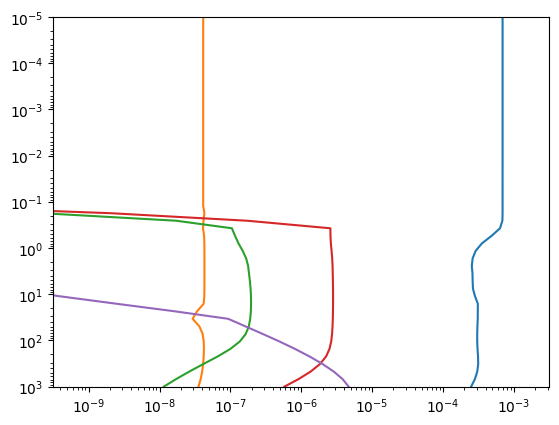

In [22]:
import pyfastchem as pyfc
import os

class FastChemistry():

    def __init__(self, pressures):

        self.pressures = pressures

        pyfc_path = '/net/lem/data1/regt/fastchem/'

        self.fastchem = pyfc.FastChem(
            f'{pyfc_path}/input/element_abundances/asplund_2020_extended.dat', 
            f'{pyfc_path}/input/logK/logK_extended.dat',
            f'{pyfc_path}/input/logK/logK_condensates.dat', 
            1)

        # Create in/out-put structures for FastChem
        self.input = pyfc.FastChemInput()
        self.input.pressure = self.pressures[::-1] # Flip to decrease

        self.output = pyfc.FastChemOutput()

        # Use equilibrium condensation
        self.input.equilibrium_condensation = True
        # Use rainout condensation approach
        self.input.rainout_condensation     = True

        # Configure FastChem's internal parameters
        self.fastchem.setParameter('accuracyChem', 1e-5)
        #self.fastchem.setParameter('accuracyElementConservation', 1e-5)
        #self.fastchem.setParameter('accuracyNewton', 1e-5)
        
        self.fastchem.setParameter('nbIterationsChem', 10000)
        #self.fastchem.setParameter('nbIterationsNewton', 10000)
        #self.fastchem.setParameter('nbIterationsNelderMead', 10000)

        # ------------------------------------------------------------------

        # Make a copy of the solar abundances from FastChem
        self.solar_abundances = np.array(self.fastchem.getElementAbundances())

        # Indices of carbon-bearing species
        self.index_C = np.array(self.fastchem.getElementIndex('C'))
        self.index_O = np.array(self.fastchem.getElementIndex('O'))

        print(self.index_C, self.index_O)

        # Compute the solar C/O ratio
        self.CO_solar = self.solar_abundances[self.index_C] / \
            self.solar_abundances[self.index_O]

        # Indices of H/He-bearing species
        index_H  = np.array(self.fastchem.getElementIndex('H'))
        index_He = np.array(self.fastchem.getElementIndex('He'))

        self.mask_metal = np.ones_like(self.solar_abundances, dtype=bool)
        self.mask_metal[index_H]  = False
        self.mask_metal[index_He] = False

    def get_VMR(self, species_i):
        index = self.fastchem.getGasSpeciesIndex(species_i)
        return self.VMR[:,index]
    
    def get_condensate_number_density(self, species_i):
        index = self.fastchem.getCondSpeciesIndex(species_i)
        return np.array(self.output.number_densities_cond)[::-1,index]

    def __call__(self, T, CO, FeH):

        temperature = T * np.ones_like(self.pressures)
        temperature[temperature<200] = 200
        self.input.temperature = temperature[::-1] # Flip for FastChem usage

        # Make a copy to modify the elemental abundances
        element_abundances = self.solar_abundances.copy()
        metallicity_wrt_solar = 10**FeH

        # Apply C/O ratio and Fe/H to elemental abundances
        element_abundances[self.index_C] = element_abundances[self.index_O] * CO
        #print(element_abundances[self.index_C] / element_abundances[self.index_O])
        #element_abundances[self.index_C] = element_abundances[self.index_O] * CO
        element_abundances[self.mask_metal] *= metallicity_wrt_solar

        # Update the element abundances
        self.fastchem.setElementAbundances(element_abundances)

        # Compute the number densities
        fastchem_flag = self.fastchem.calcDensities(self.input, self.output)

        if fastchem_flag != 0:
            # FastChem failed to converge
            print('Failed to converge')
        if np.amin(self.output.element_conserved) != 1:
            # Failed element conservation
            print('Failed element conservation')

        # Compute the volume-mixing ratio of all species
        gas_number_density_tot = np.array(self.input.pressure)*1e6 / \
            (1.3807e-16 * np.array(self.input.temperature))
        gas_number_density     = np.array(self.output.number_densities)

        self.VMR = gas_number_density / gas_number_density_tot[:,None]
        self.VMR = self.VMR[::-1] # Flip back

# Compute the chemical equilibrium abundances
FC = FastChemistry(pressures=B.PT['J1226_1'].pressure)
FC(T=B.PT['J1226_1'].temperature, CO=0.59, FeH=0.0)

FC_VMR = {hill_i: FC.get_VMR(hill_i) for hill_i in ['H2O1', 'F1H1', 'Fe1H1', 'Na', 'K']}

plt.plot(FC_VMR['H2O1'], B.PT['J1226_1'].pressure)
plt.plot(FC_VMR['F1H1'], B.PT['J1226_1'].pressure)
plt.plot(FC_VMR['K'], B.PT['J1226_1'].pressure)
plt.plot(FC_VMR['Na'], B.PT['J1226_1'].pressure)
plt.plot(FC_VMR['Fe1H1'], B.PT['J1226_1'].pressure)

plt.yscale('log'); plt.xscale('log')
plt.ylim(1e3,1e-5); plt.xlim(10**(-9.5),10**(-2.5))
plt.show()

In [32]:
def plot_condensation_curve(ax, pressure, species, FeH=-0.0, ann_kwargs=None, **kwargs):

    coeffs = {
        'CaTiO3': [5.125, -0.277, -0.554], # Wakeford et al. (2017)
        'Fe': [5.44, -0.48, -0.48], # Visscher et al. (2010)
        'Mg2SiO4': [5.89, -0.37, -0.73], # Visscher et al. (2010)
        'MgSiO3': [6.26, -0.35, -0.70], # Visscher et al. (2010)
        'Cr': [6.576, -0.486, -0.486], # Morley et al. (2012)
        'KCl': [12.479, -0.879, -0.879], # Morley et al. (2012)
        'MnS': [7.45, -0.42, -0.84], # Visscher et al. (2006)
        'Na2S': [10.05, -0.72, -1.08], # Visscher et al. (2006)
        'ZnS': [12.52, -0.63, -1.26], # Visscher et al. (2006)
        'H2S': [86.49, -8.54, -8.54], # Visscher et al. (2006)
    }

    a, b, c = coeffs[species]
    y = a + b*np.log10(pressure) + c*FeH
    T = 1e4/y
    
    ax.plot(T, pressure, **kwargs, zorder=-2)

    if ann_kwargs is None:
        return
    
    y = ann_kwargs.get('y', 1e0)
    ann_kwargs['xy'] = (np.interp(np.log10(y),np.log10(pressure),T), y)
    ann_kwargs.pop('y')

    ax.annotate(**ann_kwargs, zorder=-1)

def plot_envelopes(
        ax, y, x, x_indices=[(0,6),(1,5),(2,4)], colors=['0.0','0.5','1.0'], 
        median_kwargs=None, **kwargs
        ):
    
    x = posterior_to_envelope(x)

    patch = None
    for i, (idx_l, idx_u) in enumerate(x_indices):

        patch = ax.fill_betweenx(
            y=y, x1=x[idx_l], x2=x[idx_u], fc=colors[i], ec='none', **kwargs
            )
    
    line = None
    if median_kwargs is not None:
        idx_m = median_kwargs.get('idx', 3)
        try:
            median_kwargs.pop('idx')
        except KeyError:
            pass

        line, = ax.plot(x[idx_m], y, **median_kwargs)

    return (line, patch, line)

def posterior_to_envelope(posterior, q=0.5+1/2*np.array([-0.997,-0.95,-0.68,0.,0.68,0.95,0.997])):
    return np.quantile(posterior, q=q, axis=0)

In [33]:
def get_fine_cloud_posterior(Res, indices=[7,8,9], N=250):
    
    pressure_fine = np.logspace(
        np.log10(Res.Cloud['J1226_1'].pressure.min()), 
        np.log10(Res.Cloud['J1226_1'].pressure.max()), N
        )

    kappa_cl_0 = 10**Res.posterior[:,indices[0]]
    P_cl_0 = 10**Res.posterior[:,indices[1]]
    f_sed  = Res.posterior[:,indices[2]]

    kappa_fine = kappa_cl_0[:,None] * (pressure_fine/P_cl_0[:,None])**f_sed[:,None]
    kappa_fine[pressure_fine>P_cl_0[:,None]] = 0.

    return pressure_fine, kappa_fine

pressure_fine, A_cloud_posterior_fine = get_fine_cloud_posterior(A)
pressure_fine, B_cloud_posterior_fine = get_fine_cloud_posterior(B)

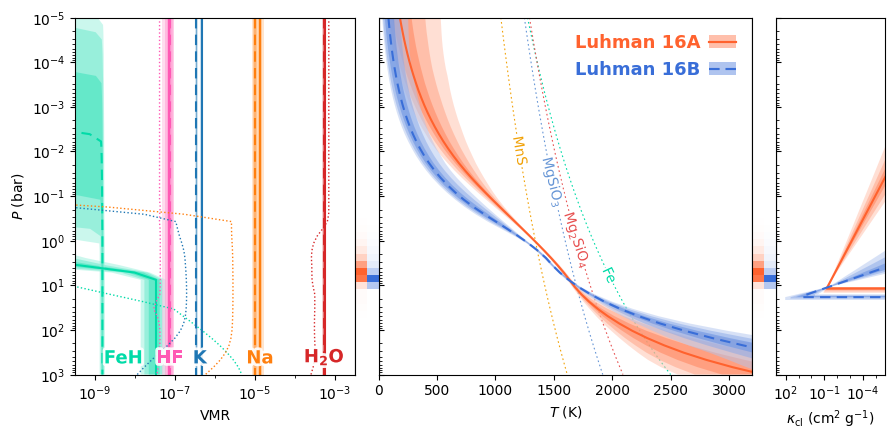

In [34]:
fig = plt.figure(figsize=(9,4.3))
gs = fig.add_gridspec(
    #nrows=1, ncols=5, hspace=0.0, wspace=0.0, width_ratios=[0.37,0.02,0.48,0.02,0.15], 
    nrows=1, ncols=5, hspace=0.0, wspace=0.0, width_ratios=[0.36,0.03,0.48,0.03,0.14], 
)
ax_VMR = fig.add_subplot(gs[0,0])
ax_PT  = fig.add_subplot(gs[0,2])
ax_cl  = fig.add_subplot(gs[0,4])
ax_contr = np.array([fig.add_subplot(gs[0,1]), fig.add_subplot(gs[0,3])])

# Emission contribution
for ax_i in ax_contr:
    ax_i.imshow(
        contr_A.reshape(-1,1), cmap=cmap_A, aspect='auto', interpolation='none', 
        extent=[0,0.5,0,1], transform=ax_i.transAxes, 
    )
    ax_i.imshow(
        contr_B.reshape(-1,1), cmap=cmap_B, aspect='auto', interpolation='none', 
        extent=[0.5,1,0,1], transform=ax_i.transAxes, 
    )
    ax_i.spines[['bottom','top']].set_visible(False)
    ax_i.set(yticks=[], xticks=[])

# PT profile
handle_A = plot_envelopes(
    ax_PT, A.PT['J1226_1'].pressure, x=A.PT['J1226_1'].temperature_posterior, 
    colors=env_colors_A, median_kwargs={'color':color_A, 'lw':lw_m}
    )
handle_B = plot_envelopes(
    ax_PT, B.PT['J1226_1'].pressure, x=B.PT['J1226_1'].temperature_posterior, 
    colors=env_colors_B, median_kwargs={'color':color_B, 'lw':lw_m, 'ls':(0,(5,3))}
    )
ax_PT.legend(
    loc='upper right', bbox_to_anchor=(1,1), frameon=False, 
    handles=[handle_A,handle_B], labels=[name_A,name_B], 
    markerfirst=False, handlelength=1.5, handletextpad=0.5, 
    labelcolor='linecolor', prop={'weight':'bold', 'size':13}, 
)


ax_PT.tick_params(axis='y', which='both', direction='in')
ax_PT.set(
    yscale='log', ylim=(1e3,1e-5), yticklabels=[], 
    xlim=(0,3200), xlabel=r'$T\ (\mathrm{K})$', xticks=np.arange(0,3500,500), 
    )

# Condensation curves
ann_kwargs = dict(
    text='Fe', y=6, clip_on=True, ha='center', va='center', 
    c='#00DBA8', fontsize=10, rotation=-65, #fontweight='bold', 
    path_effects=[pe.withStroke(linewidth=3, foreground='w')],
)
ls = (0,(1.5,2.5)); lw = 0.8
plot_condensation_curve(ax_PT, A.PT['J1226_1'].pressure, species='Fe', ann_kwargs=ann_kwargs, lw=lw, ls=ls, c=ann_kwargs['c'])

ann_kwargs['text'] = r'$\mathrm{Mg_2SiO_4}$'
ann_kwargs['y'] = 1.; ann_kwargs['c'] = '#E75252'; ann_kwargs['rotation'] = -72
plot_condensation_curve(ax_PT, A.PT['J1226_1'].pressure, species='Mg2SiO4', ann_kwargs=ann_kwargs, lw=lw, ls=ls, c=ann_kwargs['c'])

ann_kwargs['text'] = r'$\mathrm{MgSiO_3}$'
ann_kwargs['y'] = 5e-2; ann_kwargs['c'] = '#6796D6'; ann_kwargs['rotation'] = -76
plot_condensation_curve(ax_PT, A.PT['J1226_1'].pressure, species='MgSiO3', ann_kwargs=ann_kwargs, lw=lw, ls=ls, c=ann_kwargs['c'])

ann_kwargs['text'] = r'$\mathrm{MnS}$'
ann_kwargs['y'] = 1e-2; ann_kwargs['c'] = '#F1A208'; ann_kwargs['rotation'] = -80
plot_condensation_curve(ax_PT, A.PT['J1226_1'].pressure, species='MnS', ann_kwargs=ann_kwargs, lw=lw, ls=ls, c=ann_kwargs['c'])

# Clouds
plot_envelopes(
    ax_cl, pressure_fine, x=A_cloud_posterior_fine, colors=env_colors_A, median_kwargs={'color':color_A, 'lw':lw_m}
    )
plot_envelopes(
    ax_cl, pressure_fine, x=B_cloud_posterior_fine, colors=env_colors_B, median_kwargs={'color':color_B, 'lw':lw_m, 'ls':(0,(5,3))}
    )

ax_cl.tick_params(axis='y', which='both', direction='in')
ax_cl.set(
    yscale='log', ylim=(1e3,1e-5), yticklabels=[], 
    xscale='log', xticks=10.**np.array([2,-1,-4]), xlim=(6e2,2e-6), 
    xlabel=r'$\kappa_\mathrm{cl}\ (\mathrm{cm^2\ g^{-1}})$'
    )
ax_cl.set_xticks([1e1,1e0,1e-2,1e-3,1e-5], labels=[], minor=True)

# VMRs
c_species = {'HF':'#FF59B4', 'FeH':'#00DBA8', 'H2O':'C3', 'K':'C0', 'Na':'C1'}
dx_species = {'HF':+0.05, 'FeH':-0.2, 'H2O':0.0, 'K':-0.05, 'Na':-0.05}
for i, species_i in enumerate(A.Chem['J1226_1'].species):

    if species_i in ['H2', 'He']:
        continue
    
    c_i = c_species.get(species_i, 'k')
    cmap = mpl.colors.LinearSegmentedColormap.from_list('', ['w',c_i])
    env_colors_i = cmap([0.4,0.6,0.8])
    env_colors_i[:,3] = 0.5

    plot_envelopes(
        ax_VMR, A.Chem['J1226_1'].pressure, x=A.Chem['J1226_1'].VMRs_posterior[species_i], 
        colors=env_colors_i, median_kwargs={'color':c_i, 'lw':lw_m}
        )
    plot_envelopes(
        ax_VMR, B.Chem['J1226_1'].pressure, x=B.Chem['J1226_1'].VMRs_posterior[species_i], 
        colors=env_colors_i, median_kwargs={'color':c_i, 'lw':lw_m, 'ls':(0,(5,3))}
        )

    hill_i = B.Chem['J1226_1'].hill[i]
    ax_VMR.plot(FC_VMR[hill_i], B.PT['J1226_1'].pressure, c=c_i, lw=1, ls=':')

    x_i = A.Chem['J1226_1'].VMRs_posterior[species_i][0,-1]
    x_i = 10**(np.log10(x_i) + dx_species.get(species_i,0))

    if species_i == 'H2O':
        species_i = r'$\mathrm{\bf H_2O}$'

    ax_VMR.annotate(
        species_i, xy=(x_i, 0.02), xycoords=ax_VMR.get_xaxis_transform(), zorder=3, clip_on=True, 
        ha='center', va='bottom', c=c_i, fontsize=13, fontweight='bold', 
        path_effects=[pe.withStroke(linewidth=4, foreground='w', alpha=0.9)],
    )

ax_VMR.set(
    yscale='log', ylim=(1e3,1e-5), ylabel=r'$P\ (\mathrm{bar})$', 
    xscale='log', xlim=(10**(-9.5),10**(-2.5)), xlabel=r'VMR',
    )
ax_VMR.set_xticks([1e-9,1e-7,1e-5,1e-3], minor=False)
ax_VMR.set_xticks([1e-8,1e-6,1e-4,1e-3], labels=[], minor=True)

plt.subplots_adjust(left=0.08, bottom=0.13, top=0.96, right=0.98)
plt.savefig(f'./plots/J_band_profiles_new.pdf')
plt.show()